In [1]:
# importing all the required Libraries
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def loadImages(path):
    '''
        parameters
        ----------
        path : input path of the images
        
        returns
        -------
        loadedImages : list of loaded images 
    '''
    sample = []
    
    for filename in glob.glob(path):
        
        img = cv2.imread(filename)
        img = skimage.transform.resize(img, (224, 224, 3))
        IMG = np.array(img)
        sample.append(IMG)
        
    return sample

In [3]:
train_path1 = 'train/NonDemented/*.jpg' 
train_path2 = 'train/VeryMildDemented/*.jpg'
train_path3 = 'train/MildDemented/*.jpg'
train_path4 = 'train/ModerateDemented/*.jpg'

test_path1 = 'test/NonDemented/*.jpg' 
test_path2 = 'test/VeryMildDemented/*.jpg'
test_path3 = 'test/MildDemented/*.jpg'
test_path4 = 'test/ModerateDemented/*.jpg'

In [4]:
train_ND = loadImages(train_path1)
train_VMD = loadImages(train_path2)
train_MID = loadImages(train_path3)
train_MOD = loadImages(train_path4)

test_ND = loadImages(test_path1)
test_VMD = loadImages(test_path2)
test_MID = loadImages(test_path3)
test_MOD = loadImages(test_path4)

In [5]:
#%% CREATION OF DATASETS

df_train_ND = pd.DataFrame({'image':train_ND, 'label': 'ND'})
df_train_VMD = pd.DataFrame({'image':train_VMD, 'label': 'VMD'})
df_train_MID = pd.DataFrame({'image':train_MID, 'label': 'MID'})
df_train_MOD = pd.DataFrame({'image':train_MOD, 'label': 'MOD'})

df_test_ND = pd.DataFrame({'image':test_ND, 'label': 'ND'})
df_test_VMD = pd.DataFrame({'image':test_VMD, 'label': 'VMD'})
df_test_MID = pd.DataFrame({'image':test_MID, 'label': 'MID'})
df_test_MOD = pd.DataFrame({'image':test_MOD, 'label': 'MOD'})

In [6]:
final_data = [df_train_ND, df_train_VMD, df_train_MID, df_train_MOD, df_test_ND, df_test_VMD, df_test_MID, df_test_MOD]
final_data = pd.concat(final_data)

In [7]:
print("Entire data size:",final_data.shape)

Entire data size: (6400, 2)


In [8]:
#%% TRAIN LABEL SEPARATION

train_data = final_data['image']
labels = final_data['label']

In [9]:
#%% LOOKING AT THE AMOUNT OF ITEMS PER CLASS 

print("Labels Count:",Counter(np.array(labels)))

Labels Count: Counter({'ND': 3200, 'VMD': 2240, 'MID': 896, 'MOD': 64})


In [10]:
#%% ENCODING THE LABELS
from sklearn.preprocessing import LabelEncoder
onehot = LabelEncoder()
labels = onehot.fit_transform(labels)
print(labels)

[2 2 2 ... 1 1 1]


In [11]:
#%% SPLITTING INTO TRAIN AND TEST SET, TRAIN SET WILL BE FURTHER SPLIT INTO TRAIN AND VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(train_data, labels,
                                                  test_size = 0.2,
                                                  stratify = labels,
                                                  shuffle = True,
                                                  random_state = 42)

In [12]:
print('length X_train:', len(X_train))
print('length y_train:', len(y_train))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 5120
length y_train: 5120
length X_test: 1280
length y_test: 1280


In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [14]:
x_train= np.empty((len(X_train),X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2]))
for i,x in enumerate(X_train):
    x_train[i]=X_train[i]
print(x_train.shape)

(5120, 224, 224, 3)


In [15]:
x_test= np.empty((len(X_test),X_test[0].shape[0],X_test[0].shape[1],X_test[0].shape[2]))
for i,x in enumerate(X_test):
    x_test[i]=X_test[i]
print(x_test.shape)

(1280, 224, 224, 3)


In [16]:
x_train[0].shape

(224, 224, 3)

In [17]:
base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='tanh')(x)

predictions = Dense(4, activation='tanh')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
test_features=model_feat.predict(x_test)

In [18]:
# Getting Train and validation accuracy
x_train_acc, x_val_acc, y_train_acc, y_val_acc = train_test_split(train_features,y_train,
                                                  test_size = 0.2,
                                                  stratify = y_train,
                                                  shuffle = True,
                                                  random_state = 42)

In [19]:
X_test,y_test=test_features,y_test

In [20]:
print('length X_train:', len(x_train_acc))
print('length y_train:', len(y_train_acc))

print('length X_val:',  len(x_val_acc))
print('length y_val:', len(y_val_acc))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 4096
length y_train: 4096
length X_val: 1024
length y_val: 1024
length X_test: 1280
length y_test: 1280


In [21]:
#%% Fitting Model and Predicting the validationa and test cases

model=AdaBoostClassifier()
model.fit(x_train_acc,y_train_acc)
          
y_pred_train= model.predict(x_train_acc)
y_pred_val=model.predict(x_val_acc)
y_pred_test=model.predict(X_test)

Counter({2: 2048, 3: 1433, 0: 574, 1: 41})
Counter({2: 3280, 3: 812, 0: 4})


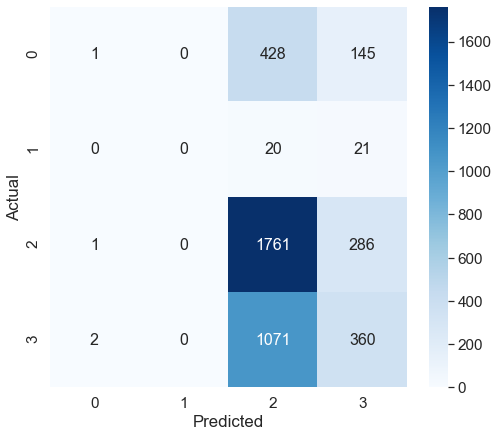

<Figure size 432x288 with 0 Axes>

In [22]:
print(Counter(y_train_acc))
print(Counter(y_pred_train))

conf_mx = confusion_matrix(y_train_acc, y_pred_train)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y_train_acc), index = np.unique(y_train_acc))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sn.set(font_scale=1.4) # For label size
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
plt.savefig('train confusion matrix.png')

Counter({2: 512, 3: 359, 0: 143, 1: 10})
Counter({2: 812, 3: 209, 0: 3})


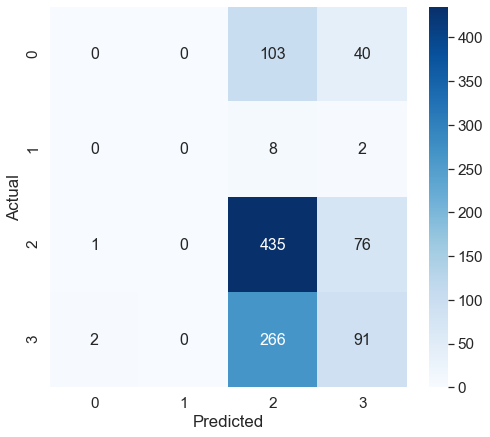

<Figure size 432x288 with 0 Axes>

In [23]:
print(Counter(y_val_acc))
print(Counter(y_pred_val))

conf_mx = confusion_matrix(y_val_acc, y_pred_val)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y_train_acc), index = np.unique(y_train_acc))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sn.set(font_scale=1.4) # For label size
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
plt.savefig('validation confusion matrix.png')

Counter({2: 640, 3: 448, 0: 179, 1: 13})
Counter({2: 1004, 3: 276})


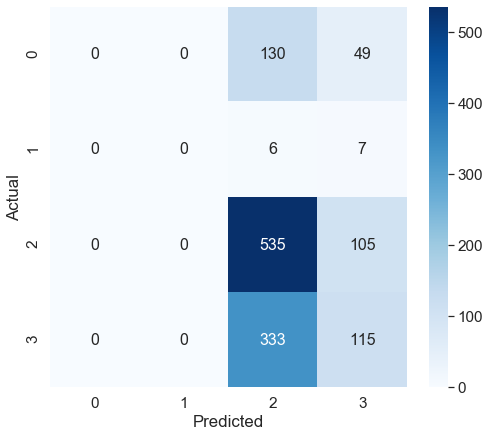

<Figure size 432x288 with 0 Axes>

In [24]:
#%% CONFUSION MATRIX
print(Counter(y_test))
print(Counter(y_pred_test))

conf_mx = confusion_matrix(y_test, y_pred_test)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sn.set(font_scale=1.4) # For label size
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
plt.savefig('test confusion matrix.png')

In [25]:
def print_performance_metrics(y_test, max_y_pred_test):
    """
        parameters
        ----------
        y_test : actual label (must be in non-one hot encoded form)
        y_pred_test : predicted labels (must be in non-one hot encoded form, common output of predict methods of classifers)

        returns
        -------
        prints the accuracy, precision, recall, F1 score, ROC AUC score, Cohen Kappa Score, Matthews Corrcoef and classification report   
    
    """
    print('Accuracy:', np.round(metrics.accuracy_score(y_test, max_y_pred_test),4))
    print('Precision:', np.round(metrics.precision_score(y_test, max_y_pred_test, average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, max_y_pred_test, average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, max_y_pred_test, average='weighted'),4))
    #print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test,  max_y_pred_test,multi_class='ovo', average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, max_y_pred_test),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, max_y_pred_test),4)) 
    print('\t\tClassification Report:\n', metrics.classification_report(y_test, max_y_pred_test))

In [26]:
print('------------------------ train set ------------------------')
print_performance_metrics(y_pred_train,y_train_acc)

print('------------------------ validation set ------------------------')
print_performance_metrics(y_pred_val,y_val_acc)

print('------------------------ test set ------------------------')
print_performance_metrics(y_pred_test,y_test)


------------------------ train set ------------------------
Accuracy: 0.5181
Precision: 0.7384
Recall: 0.5181
F1 Score: 0.5929
Cohen Kappa Score: 0.0909
Matthews Corrcoef: 0.1093
		Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.25      0.00         4
           1       0.00      0.00      0.00         0
           2       0.86      0.54      0.66      3280
           3       0.25      0.44      0.32       812

    accuracy                           0.52      4096
   macro avg       0.28      0.31      0.25      4096
weighted avg       0.74      0.52      0.59      4096

------------------------ validation set ------------------------
Accuracy: 0.5137
Precision: 0.7254
Recall: 0.5137
F1 Score: 0.5865
Cohen Kappa Score: 0.0851
Matthews Corrcoef: 0.1011
		Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.

C:\Users\iamma\.conda\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iamma\.conda\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
